In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [3]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[(df_cus_orig.first_order_created_datetime >= "2017-01-01")
                          & (df_cus_orig.last_order_created_datetime <= "2018-09-30")].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

33304 / 68891


In [4]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')

In [5]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_id': 'nunique'}).reset_index()
df_items = df_items.rename(columns={'product_id': 'num_products'})
df_ord = df_ord.merge(df_items, on=['order_id'], how='left')

In [6]:
df_braze = pd.read_csv('../data/braze_customers.csv')
df_braze = df_braze[['customer_id', 'email_subscribe', 'push_subscribe']]
df_braze.email_subscribe = df_braze.email_subscribe.isin(['subscribed', 'opted_in'])
df_braze.push_subscribe = df_braze.push_subscribe.isin(['subscribed', 'opted_in'])

df_ord = df_ord.merge(df_braze, on='customer_id', how='left')
df_ord.email_subscribe = df_ord.email_subscribe.fillna(False)
df_ord.push_subscribe = df_ord.push_subscribe.fillna(False)

In [7]:
df_ord['days_since_last_seen'] = (datetime(2018,9,30) - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days
df_ord.order_created_datetime = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_day'] = (df_ord.order_created_datetime - datetime(2017, 1, 1)).dt.days
df_ord['order_weekday'] = (df_ord.order_created_datetime).dt.weekday
df_ord['order_month'] = (df_ord.order_created_datetime).dt.month

In [8]:
df_ord = df_ord.drop_duplicates()

In [9]:
last_day = (datetime(2018,9,30) - datetime(2017,1,1)).days
last_day

637

In [10]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,completed_orders,last_order_created_datetime,quantity,num_products,email_subscribe,push_subscribe,days_since_last_seen,order_day,order_weekday,order_month
0,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,21,2018-09-26 10:18:16,1.0,1.0,True,True,3,583,1,8
1,DE-B-20696,5a1ee6e144770903118b466f,5abe2737467709f94e8b4695,52.491111,13.429692,2018-04-04 06:00:00,2018-04-04 07:00:00,12047,completed,2018-03-30 14:01:59,...,21,2018-09-26 10:18:16,2.0,1.0,True,True,3,453,4,3
2,DE-B-72139,5a1ee6e144770903118b466f,5b8a56d5ee1b6a373e38f39c,52.491111,13.429692,2018-09-03 10:00:00,2018-09-03 11:00:00,12047,completed,2018-09-01 11:07:33,...,21,2018-09-26 10:18:16,1.0,1.0,True,True,3,608,5,9
3,DE-B-87918,5a1ee6e144770903118b466f,5afc6c33c3436275d6724815,52.491111,13.429692,2018-05-22 07:00:00,2018-05-22 08:00:00,12047,completed,2018-05-16 19:36:51,...,21,2018-09-26 10:18:16,3.0,1.0,True,True,3,500,2,5
4,DE-C-27253,5a1ee6e144770903118b466f,5b20cb79ee1b6a090e115c25,52.491111,13.429692,2018-06-16 12:00:00,2018-06-16 13:00:00,12047,completed,2018-06-13 09:44:57,...,21,2018-09-26 10:18:16,1.0,1.0,True,True,3,528,2,6


In [11]:
sorted(df_ord.columns)

['activity_state',
 'aov',
 'churn_factor',
 'city',
 'cluster',
 'cluster_name',
 'completed_orders',
 'corporate',
 'customer_db_id',
 'customer_id',
 'customer_rescheduled',
 'days_since_last_order',
 'days_since_last_seen',
 'days_until_next_order',
 'delay_mins_DO',
 'delay_mins_PU',
 'driver_db_id_DO',
 'driver_db_id_PU',
 'email',
 'email_subscribe',
 'fac_name',
 'final_click_channel',
 'final_click_no_voucher',
 'frequency',
 'gender',
 'internal_rescheduled',
 'last_order',
 'last_order_created_datetime',
 'newsletter_optin',
 'num_customer_reschedules',
 'num_internal_reschedules',
 'num_orders',
 'num_products',
 'order_created_datetime',
 'order_day',
 'order_db_id',
 'order_id',
 'order_month',
 'order_num',
 'order_state',
 'order_weekday',
 'order_x',
 'order_y',
 'origin',
 'pickup_timeslot_from_datetime',
 'pickup_timeslot_to_datetime',
 'pickup_zip',
 'product_DC',
 'product_HH',
 'product_LA',
 'product_WF',
 'product_combinations',
 'product_type',
 'punctual_5min_

### Completed Dataset

In [12]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['completed_orders'] = df_comp.groupby(['customer_db_id']).transform('count')
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [13]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['order_day'] = (df_comp.order_created_datetime - datetime(2017, 1, 1)).dt.days

# Customer Lifetime
Created dataframe for customer lifetime

In [14]:
df_life = df_comp.copy()
df_life = df_life.sort_values(['customer_id', 'order_day'])

df_life['first_order'] = df_life.order_comp_num == 0
df_life['last_order'] = df_life.order_comp_num == (df_life.completed_orders - 1)
df_life['returned'] = ~df_life.last_order

df_life['frequency'] = df_life.groupby('customer_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())
df_life['order_day_expected'] = df_life.order_day + df_life.frequency
df_life.order_day_expected = df_life.groupby('customer_id').order_day_expected.shift().fillna(df_life.order_day)
df_life['order_expected_diff'] = df_life.order_day - df_life.order_day_expected

df_life['churn_factor'] = df_life.days_until_next_comp / df_life.frequency
df_life.loc[df_life.last_order, 'churn_factor'] = df_life.days_since_last_seen / df_life.frequency

df_life['order_day_expected_45'] = df_life.order_day + 45 + 8
df_life.order_day_expected_45 = df_life.groupby('customer_id').order_day_expected_45.shift().fillna(df_life.order_day)
df_life['order_expected_45_diff'] = df_life.order_day - df_life.order_day_expected_45

df_life['churned_after'] = df_life.days_until_next_comp > (45 + 8)
df_life.loc[df_life.last_order, 'churned_after'] = df_life.days_since_last_seen > (45 + 8)
df_life['churned_before'] = df_life.groupby('customer_id').churned_after.shift().fillna(False)
df_life.loc[df_life.churned_after, 'entered_inactive'] = df_life.order_day + 45 + 8

df_life['revenue_voucher'] = df_life.revenue + df_life.voucher_value
df_life.loc[~(df_life.voucher_value > 0), 'voucher_channel'] = 'no_voucher'
df_life['voucher_ratio'] = (df_life.voucher_value / df_life.revenue_voucher).round(1)

df_life['returned_CRM'] = df_life.final_click_channel.str.contains('crm')
df_life['returned_CRM'] = df_life.groupby('customer_id').returned_CRM.shift(-1).fillna(False)
df_life['returned_voucher'] = df_life.groupby('customer_id').voucher_value.shift(-1).fillna(0)
df_life['returned_voucher'] = (df_life.returned_voucher > 0)
df_life['over_frequency'] = df_life.churn_factor >= 1
df_life['freq_median'] = df_life.groupby('order_day')['frequency'].transform('median')

In [15]:
df_life.voucher_channel = df_life.voucher_channel.fillna('unknown')

### Sample Customer

In [16]:
def plot_customer_lifetime(sample_customer):
    df_life_sample = df_life.loc[df_life.customer_id == sample_customer]
    
    fig, ax = plt.subplots(figsize=(10,5))
    # plot vouchers
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.voucher_value > 0], 
                    x='order_day', y='voucher_value', marker='x', color='black', label='voucher_value')
    
    # plot journey and expected journy
    sns.lineplot(data=df_life_sample, x='order_day', y='revenue_voucher', 
                 marker='o', label='order revenue', color='green')
    sns.lineplot(data=df_life_sample, x='order_day_expected', y='revenue_voucher', 
                 marker='o', label='expected_order', color='gray', alpha=0.3)
    
    # plot final click channel
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.final_click_channel.str.contains('crm')],
                   x='order_day', y='revenue_voucher', color='red', label='crm_click', zorder=10)
    
    # plot entering inactive segment
    sns.rugplot(df_life_sample.entered_inactive, color='black', height=1, linestyle='--', label='inactive')
    

    plt.xticks(rotation=70)
    plt.ylim(0)
    plt.title(sample_customer)
    plt.legend()
    plt.show()

In [17]:
samples = df_ord.loc[(df_ord.days_until_next_order > 50) & (df_ord.completed_orders > 3) & (df_ord.order_num == 2)]['customer_id'].sample(3)
samples

24422    CUS-P3835452
77559    CUS-M9906609
74830    CUS-S4128430
Name: customer_id, dtype: object

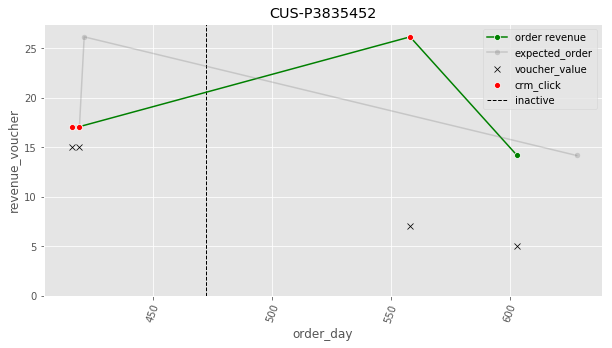

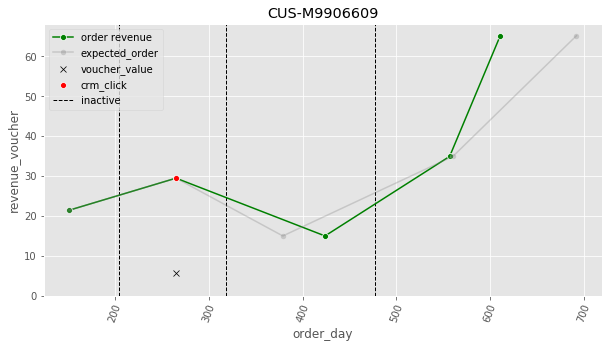

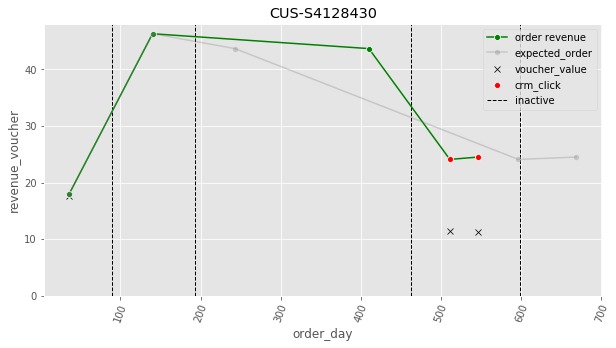

In [18]:
for s in samples:
    plot_customer_lifetime(s)

# Incentive Analysis
- How does incentive of churn impact if customers return

In [19]:
# analyse voucher usage

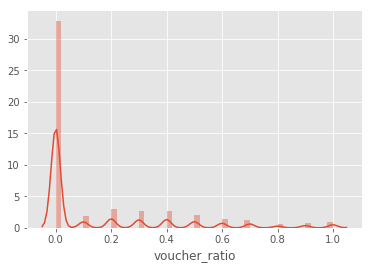

In [31]:
sns.distplot(df_life.voucher_ratio.fillna(0))

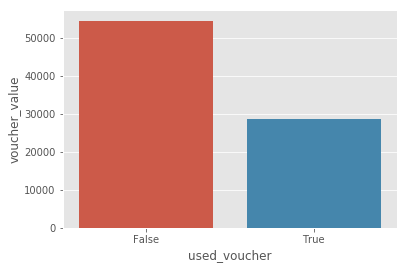

In [47]:
a = (df_life.voucher_value > 0).value_counts().reset_index().rename(columns={'index': 'used_voucher'})
sns.categorical.barplot(data=a, x='used_voucher', y='voucher_value')

In [50]:
a = df_life.loc[df_life.churned_after].groupby(['returned', 'returned_voucher'])['order_id'].nunique()
a

returned  returned_voucher
False     False               22778
True      False                6851
          True                 4618
Name: order_id, dtype: int64

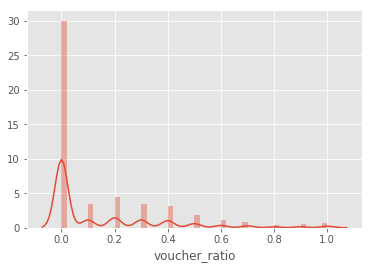

In [57]:
sns.distplot(df_life.loc[df_life.churned_before].voucher_ratio)